In [15]:
import os
import time
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

t = time.time()

In [2]:
review = pd.read_pickle('data/CD_review_stop_lem.pickle')
review

6          recall love album maybe one forgot figure arti...
32         keith green song shepherd previous album focus...
37         keith green passionate love jesus evident life...
117        buy replace original purchase many year ago so...
150        love cd always part christmas music drive rhyt...
                                 ...                        
4543140                                             good job
4543226                                           love heart
4543228    ann still get doubt seriously ever ever lose v...
4543263    first hear guy pick ocean avenue three album g...
4543359                        really good fun quality stuff
Name: reviewText, Length: 453866, dtype: object

In [3]:
ratings = pd.read_pickle('data/CD_ratings.pickle')
ratings

6          5
32         5
37         5
117        5
150        5
          ..
4543140    4
4543226    5
4543228    5
4543263    5
4543359    5
Name: overall, Length: 453866, dtype: int64

In [4]:
X = review
y = ratings

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [5]:
pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression())])

parameters = {'vect__max_df': (0.5, 0.75, 1),
              'vect__max_features': (5000, 10000, 50000), 
              'vect__ngram_range': ((1,1), (1,2)),
              'tfidf__use_idf': (True, False),
              'clf__penalty': ('l1', 'l2'), 
              'clf__C': np.logspace(-4,4,5)
}
              
grid_search = GridSearchCV(pipeline, parameters, scoring='neg_root_mean_squared_error', n_jobs=3, verbose=1)
    
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time.time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))         

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1), 'vect__max_features': (5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2)), 'tfidf__use_idf': (True, False), 'clf__penalty': ('l1', 'l2'), 'clf__C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04])}
Fitting 5 folds for each of 360 candidates, totalling 1800 fits


C:\Users\Vincent\anaconda3\envs\WM-project\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
900 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
900 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Vincent\anaconda3\envs\WM-project\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Vincent\anaconda3\envs\WM-project\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Vincent\anaconda3\envs\WM-project\lib\site-packages\sklearn\linear_model\_logistic.p

done in 40377.061s

Best score: -0.827
Best parameters set:
	clf__C: 100.0
	clf__penalty: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__max_features: 50000
	vect__ngram_range: (1, 2)


C:\Users\Vincent\anaconda3\envs\WM-project\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
y_pred = grid_search.predict(X_test)

print("RMSE:", metrics.mean_squared_error(y_test, y_pred, squared=False))

RMSE: 0.8367922141672468


In [7]:
print("MAE:", metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.41173204544052455


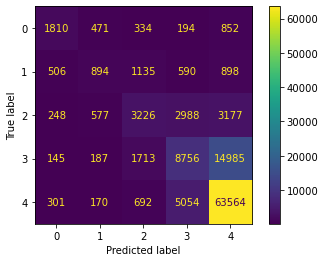

In [12]:
display = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred))
display.plot()

In [16]:
outfile = open('results/LR_results.pickle', 'wb')
pickle.dump(y_pred, outfile)
outfile.close()

In [8]:
print(f"Execution time : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Execution time : 11:13:13
